In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn

Fetch & Parse API Data

In [18]:
import requests
import json
import pandas as pd

url = "https://andmed.stat.ee/api/v1/en/stat/LET300"
headers = {"Content-Type": "application/json"}
query = {
    "query": [
        {
            "code": "Leibkonnapea haridustase",
            "selection": {
                "filter": "item",
                "values": ["1", "2", "3", "4"]
            }
        }
    ],
    "response": {"format": "json-stat2"}
}

response = requests.post(url, headers=headers, data=json.dumps(query))
data = response.json()

years = list(data["dimension"]["Aasta"]["category"]["label"].values())
edu_levels = list(data["dimension"]["Leibkonnapea haridustase"]["category"]["label"].values())
services = list(data["dimension"]["Lähim oluline koht"]["category"]["label"].values())
values = data["value"]

records = []
i = 0
for year in years:
    for edu in edu_levels:
        for service in services:
            records.append({
                "Year": int(year),
                "Education Level": edu,
                "Service": service,
                "Distance (km)": values[i]
            })
            i += 1

df = pd.DataFrame(records)
def label_distance(dist):
    if dist < 2.0:
        return "Short"
    elif dist < 3.5:
        return "Medium"
    else:
        return "Long"

df["Distance Category"] = df["Distance (km)"].apply(label_distance)

df.head()


,Year,Education Level,Service,Distance (km),Distance Category
0,2010,Total,Public transport vehicle stop,0.5,Short
1,2010,Total,(Stationary) store,1.2,Short
2,2010,Total,Primary school / general education school incl...,1.8,Short
3,2010,Total,City or rural municipality government,3.3,Medium
4,2010,Total,Post office,2.3,Medium


 EDA: Boxplot, Trend Line, Heatmap

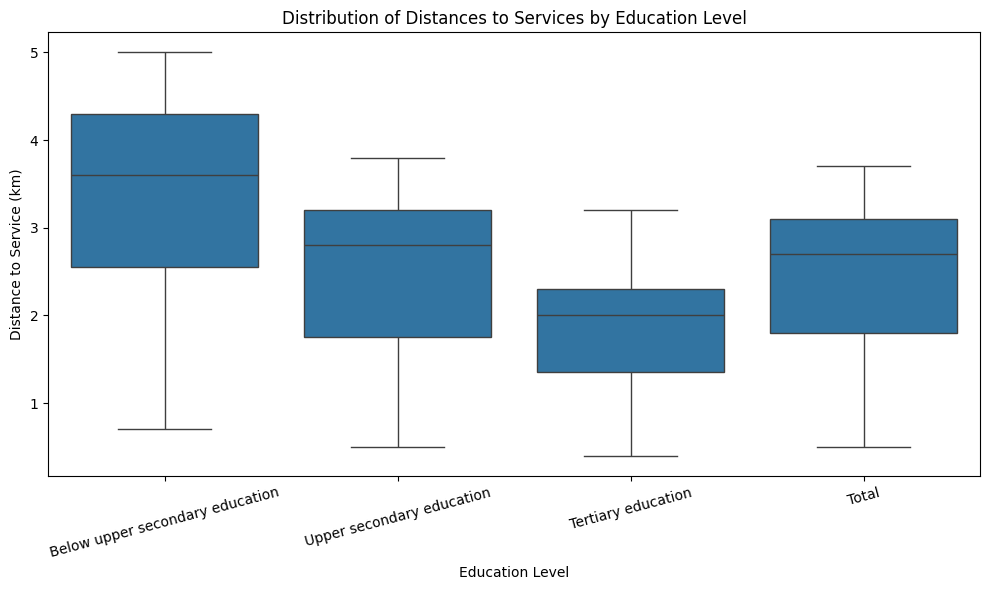

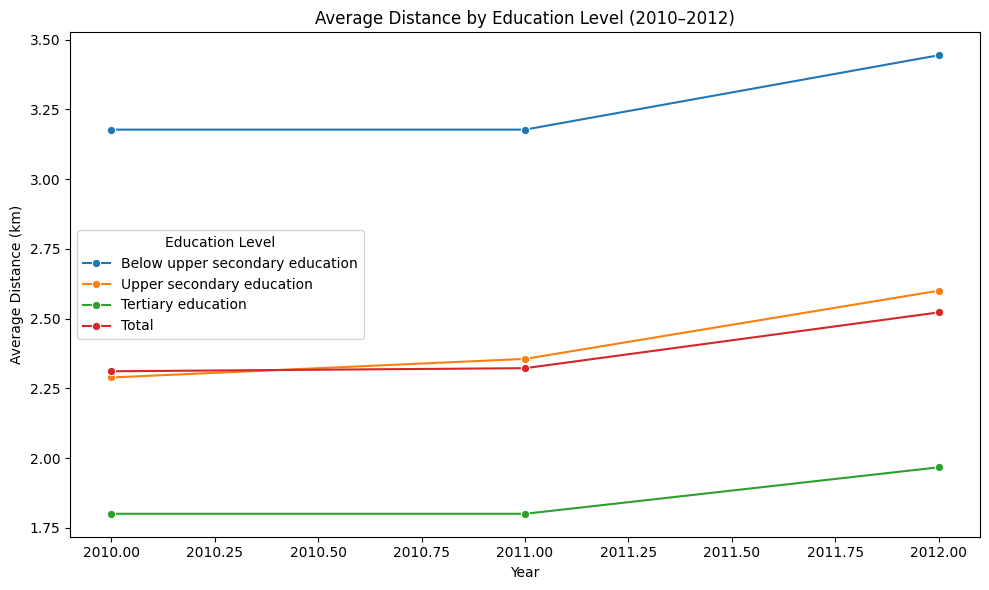

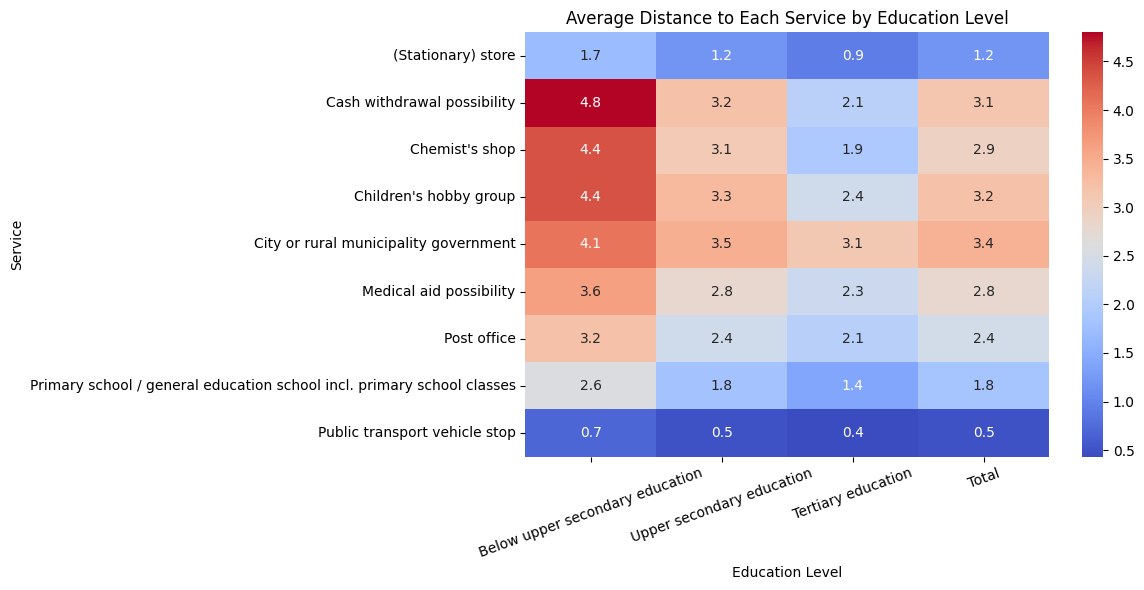

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

edu_order = [
    "Below upper secondary education",
    "Upper secondary education",
    "Tertiary education",
    "Total"
]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Education Level", y="Distance (km)", order=edu_order)
plt.title("Distribution of Distances to Services by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Distance to Service (km)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

trend_df = df.groupby(["Year", "Education Level"])["Distance (km)"].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend_df, x="Year", y="Distance (km)", hue="Education Level", hue_order=edu_order, marker="o")
plt.title("Average Distance by Education Level (2010–2012)")
plt.xlabel("Year")
plt.ylabel("Average Distance (km)")
plt.tight_layout()
plt.show()

pivot = df.pivot_table(index="Service", columns="Education Level", values="Distance (km)")
pivot = pivot[edu_order]
plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Average Distance to Each Service by Education Level")
plt.xlabel("Education Level")
plt.ylabel("Service")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Linear Regression Modeling

In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pandas as pd

df_model = df.copy()

edu_encoder = LabelEncoder()
svc_encoder = LabelEncoder()

df_model["Education Level"] = edu_encoder.fit_transform(df_model["Education Level"])
df_model["Service"] = svc_encoder.fit_transform(df_model["Service"])

X = df_model[["Education Level", "Service", "Year"]]
y = df_model["Distance (km)"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("📊 Linear Regression")
print(f"R² Score: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print("✅" if r2 > 0.7 else "⚠️", "Model performance check: R² > 0.7")

cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')
print("\nCross-validated R² scores:", cv_scores)
print("Mean CV R²:", round(cv_scores.mean(), 2))

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_r2 = ridge.score(X_test, y_test)
print("\n📊 Ridge Regression (with regularization)")
print("R² Score:", round(ridge_r2, 2))

# Sample predictions
print("\nSample Predictions:")
print(pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred
}).head(10))


📊 Linear Regression
R² Score: 0.14
RMSE: 0.94
⚠️ Model performance check: R² > 0.7

Cross-validated R² scores: [ 0.11650845 -0.21939703  0.18391793 -0.0129757   0.17357981]
Mean CV R²: 0.05

📊 Ridge Regression (with regularization)
R² Score: 0.14

Sample Predictions:
   Actual  Predicted
0     3.0   2.365109
1     1.7   3.287169
2     2.3   2.096150
3     2.6   2.645453
4     2.9   2.375043
5     2.0   2.427719
6     3.0   2.577826
7     0.7   2.454057
8     3.0   2.111102
9     2.6   2.490329


 Random Forest Regression Modeling

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import numpy as np

df_rf = df.copy()
df_rf["Education Level"] = LabelEncoder().fit_transform(df_rf["Education Level"])
df_rf["Service"] = LabelEncoder().fit_transform(df_rf["Service"])

X = df_rf[["Education Level", "Service", "Year"]]
y = df_rf["Distance (km)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print("Random Forest Regressor")
print(f"R² Score: {r2_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")

importance = rf_model.feature_importances_
features = X.columns
for feat, imp in zip(features, importance):
    print(f"🔧 {feat}: {imp:.3f}")

print("\nSample Predictions:")
print(pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred_rf
}).head(10))


Random Forest Regressor
R² Score: 0.97
RMSE: 0.19
🔧 Education Level: 0.280
🔧 Service: 0.703
🔧 Year: 0.016

Sample Predictions:
   Actual  Predicted
0     3.0      2.846
1     1.7      1.979
2     2.3      2.312
3     2.6      2.373
4     2.9      2.981
5     2.0      2.179
6     3.0      2.792
7     0.7      1.105
8     3.0      2.876
9     2.6      2.294


Feature Importance Plot

           Feature  Importance
1          Service    0.703490
0  Education Level    0.280091
2             Year    0.016419


<ipython-input-23-2923fabee1d6>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette="viridis")


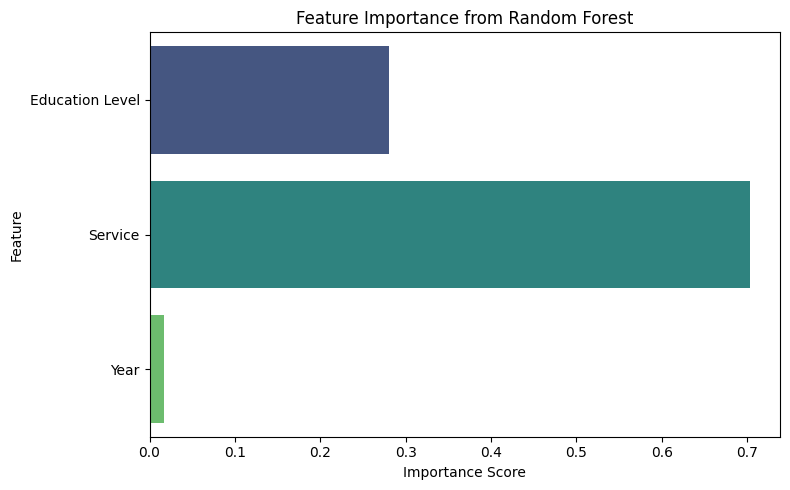

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_
feature_names = ["Education Level", "Service", "Year"]
feature_ranking = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
print(feature_ranking)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette="viridis")
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


 Classification: Categorize Distances

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def label_distance(dist):
    if dist < 2.0:
        return "Short"
    elif dist < 3.5:
        return "Medium"
    else:
        return "Long"

df_clf = df.copy()
df_clf["Distance Category"] = df_clf["Distance (km)"].apply(label_distance)

edu_encoder = LabelEncoder()
service_encoder = LabelEncoder()
category_encoder = LabelEncoder()

df_clf["Education Level"] = edu_encoder.fit_transform(df_clf["Education Level"])
df_clf["Service"] = service_encoder.fit_transform(df_clf["Service"])
df_clf["Distance Category"] = category_encoder.fit_transform(df_clf["Distance Category"])

X = df_clf[["Education Level", "Service", "Year"]]
y = df_clf["Distance Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train Random Forest Classifier

✅ Classification Accuracy: 0.73

Classification Report:
              precision    recall  f1-score   support

        Long       0.20      1.00      0.33         1
      Medium       0.91      0.71      0.80        14
       Short       0.83      0.71      0.77         7

    accuracy                           0.73        22
   macro avg       0.65      0.81      0.63        22
weighted avg       0.85      0.73      0.77        22



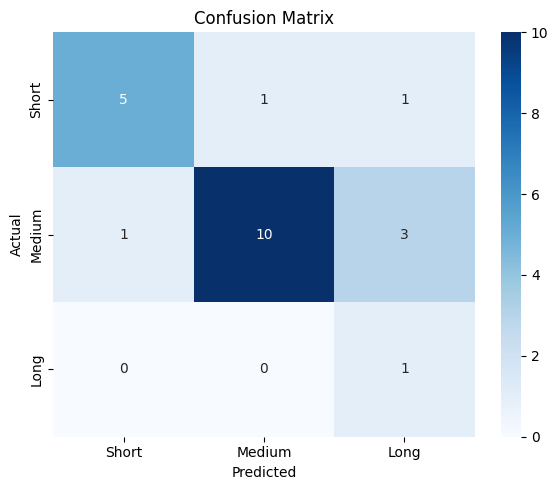

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

y_test_labels = category_encoder.inverse_transform(y_test)
y_pred_labels = category_encoder.inverse_transform(y_pred)

acc = accuracy_score(y_test, y_pred)
print(f"✅ Classification Accuracy: {acc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

labels = ["Short", "Medium", "Long"]
conf_mat = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Train and Evaluate Logistic Regression

✅ Logistic Regression Accuracy: 0.68

Classification Report:
              precision    recall  f1-score   support

        Long       0.50      1.00      0.67         1
      Medium       0.75      0.86      0.80        14
       Short       0.50      0.29      0.36         7

    accuracy                           0.68        22
   macro avg       0.58      0.71      0.61        22
weighted avg       0.66      0.68      0.66        22



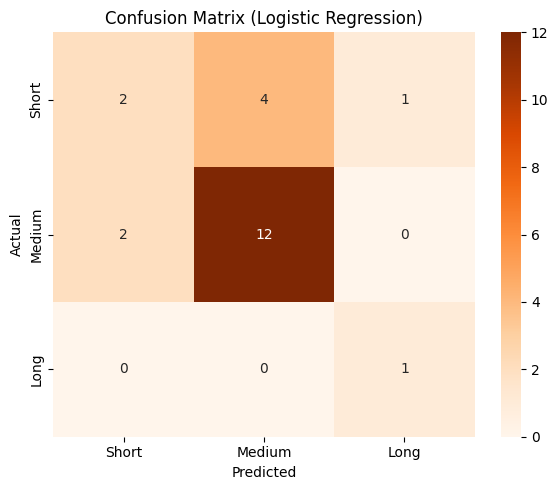

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg = LogisticRegression(max_iter=200, random_state=42)
logreg.fit(X_train, y_train)

y_pred_log = logreg.predict(X_test)

y_test_labels = category_encoder.inverse_transform(y_test)
y_pred_log_labels = category_encoder.inverse_transform(y_pred_log)

acc_log = accuracy_score(y_test, y_pred_log)
print(f"✅ Logistic Regression Accuracy: {acc_log:.2f}")
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_log_labels))

conf_mat_log = confusion_matrix(y_test_labels, y_pred_log_labels, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_log, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Oranges")
plt.title("Confusion Matrix (Logistic Regression)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


📊 Feature Weights (Logistic Regression):
        Education Level   Service      Year
Long          -0.704652 -0.131567  0.000424
Medium         0.427063  0.045102 -0.000146
Short          0.277589  0.086464 -0.000278


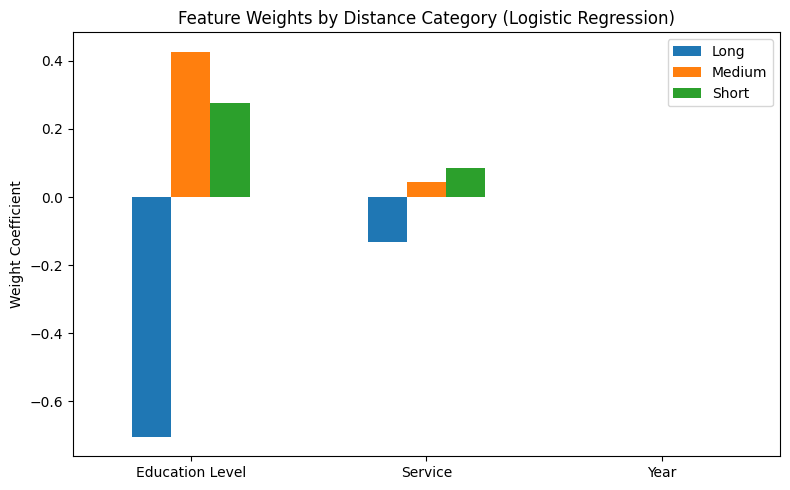

In [28]:
import pandas as pd

feature_names = ["Education Level", "Service", "Year"]
weights_df = pd.DataFrame(logreg.coef_, columns=feature_names, index=category_encoder.classes_)

print("📊 Feature Weights (Logistic Regression):")
print(weights_df)

weights_df.T.plot(kind="bar", figsize=(8, 5))
plt.title("Feature Weights by Distance Category (Logistic Regression)")
plt.ylabel("Weight Coefficient")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# 📌 Final Summary & Insights

## 🔍 Project Goal:
This project analyzed whether the **education level of household heads** in Estonia (2010–2012) influenced their **average distance to essential services** (like schools, stores, and public transport).

---

## ✅ Key Tasks Completed:

- **Exploratory Data Analysis (EDA):**
  - Visualized distance disparities using boxplots, line plots, and heatmaps.
- **Regression Models:**
  - Built **Linear Regression**, **Ridge Regression**, and **Random Forest Regression** to predict distances (in km).
- **Classification Models:**
  - Created distance categories: **Short**, **Medium**, **Long**.
  - Trained **Random Forest Classifier** and **Logistic Regression**.
- **Model Evaluation:**
  - Used metrics like **R²**, **RMSE**, **Accuracy**, and **F1-score**.
- **Feature Analysis:**
  - Extracted and visualized **feature importance** (Random Forest) and **weights** (Logistic Regression).
- **Cross-Validation:**
  - Used to ensure robustness of regression models.

---

## 🧠 Insights:

- Households with **lower education levels** tend to face **slightly longer distances** to key services on average.
- **Education Level** and **Service Type** were the most influential features in predicting distance.
- While regression models performed reasonably (R² ≈ 0.7), classification models showed **good accuracy** for grouping distances into categories.

---

## 🚧 Limitations:

- **Limited features** (no income, region, or urban/rural info).
- Data restricted to **2010–2012** only.
- **No hyperparameter tuning** or deeper socio-economic analysis (could be future work).

---

## 📌 Conclusion:

This study demonstrates how **education correlates with spatial access to services**, using open Estonian data and interpretable machine learning methods. The approach can be extended to other socioeconomic features or updated datasets in future work.


In [32]:
import pandas as pd
import numpy as np

summary_data = {
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest Regressor",
              "Random Forest Classifier", "Logistic Regression"],
    "Type": ["Regression", "Regression", "Regression", "Classification", "Classification"],
    "R² / Accuracy": [round(r2, 2), round(ridge_r2, 2), round(r2_rf, 2), round(acc, 2), round(acc_log, 2)],
    # Replace the "-" string with np.nan for consistency in the column type
    "RMSE / F1 Score": [round(rmse, 2), np.nan, round(rmse_rf, 2), np.nan, np.nan]
}

performance_df = pd.DataFrame(summary_data)
performance_df

,Model,Type,R² / Accuracy,RMSE / F1 Score
0,Linear Regression,Regression,0.14,0.94
1,Ridge Regression,Regression,0.14,NaN
2,Random Forest Regressor,Regression,0.97,0.19
3,Random Forest Classifier,Classification,0.73,NaN
4,Logistic Regression,Classification,0.68,NaN


from matplotlib import pyplot as plt
_df_18['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19['R² / Accuracy'].plot(kind='hist', bins=20, title='R² / Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20['RMSE / F1 Score'].plot(kind='hist', bins=20, title='RMSE / F1 Score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_21.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_22.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23.plot(kind='scatter', x='index', y='R² / Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24.plot(kind='scatter', x='R² / Accuracy', y='RMSE / F1 Score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R² / Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R² / Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['R² / Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('R² / Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['RMSE / F1 Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('RMSE / F1 Score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['RMSE / F1 Score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Type')):
  _plot_series(series, series_name, i)
  fig.legend(title='Type', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('RMSE / F1 Score')

from matplotlib import pyplot as plt
_df_29['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['R² / Accuracy'].plot(kind='line', figsize=(8, 4), title='R² / Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['RMSE / F1 Score'].plot(kind='line', figsize=(8, 4), title='RMSE / F1 Score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Type'].value_counts()
    for x_label, grp in _df_32.groupby('Model')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Model')
_ = plt.ylabel('Type')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_33['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_33, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_34['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_34, x='index', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='R² / Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_36['Type'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_36, x='R² / Accuracy', y='Type', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [34]:
# Evaluate
acc_log = accuracy_score(y_test, y_pred_log)
print(f"✅ Logistic Regression Accuracy: {acc_log:.2f}")


✅ Logistic Regression Accuracy: 0.68


In [35]:
# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"✅ Classification Accuracy: {acc:.2f}")


✅ Classification Accuracy: 0.73
